# TD 1
> Building the Dataset
1. Load Dataset
5. Plot the distribution of your target.
9. Create a validation dataset: save all data after 3000 lines and keep it in a `val_dataset`, then remove it from your main dataset.

> Making First Predictions
1. Do a first prediction with a simple train-test split.
2. Show accuracy score and confusion matrix.

> Trace your own PR curve
1. Do the same a before but use `predict_proba`
2. convert your result in binary output ( e.g 0 and 1)
3. do that with a threshold between 0 and 1 with a step of 0.1
4. calculate your Precision and your Recall
5. plot the curve

> Building a More Robust Model
1. Create a function that takes as input a dataset, a type of cross-validation (`Xval`), and a metric:
    1. Declare a model.
    2. Create an `Xval` object with a `random_state` of 42.
    3. Train a model for each fold.
    4. Save the score on the test fold.
    5. Save the model of this fold
    5. Return all the scores.
2. Run your function with `Kfold` and `StratifiedKfold`.
3. Display the results by fold.

> Enhancing the Results
1. Repeat the same process with downsampling 
2. Repeat the same process with resampling
3. Use SMOTE and repeat the same process.
4. Use `class_weight` params and repeat the same process.
6. Plot all the results and compare.

> Checking if the Results Fit the Reality
1. Take the same model you used previously.
2. For each technique you implemented, train your model with all the data (no `Xval`) and predict on the validation dataset.
3. Look at the impact on performance for the validation period with your predictions.
4. Plot all the results and compare.

In [1]:
%load_ext autoreload

In [33]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.over_sampling import ADASYN, SMOTE
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from sklearn import tree
from sklearn.datasets import make_classification
from sklearn.ensemble import (
    GradientBoostingClassifier,
    IsolationForest,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_recall_curve,
)
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    TimeSeriesSplit,
    cross_validate,
    train_test_split,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

pio.templates.default = "plotly_white"

%autoreload 2

In [34]:
data = pd.read_csv("TP1_data.csv", sep=";")
col = data.corr()["target"].sort_values()[:30].index.tolist() + ["target"]
data = data[col]
# data.to_csv("TP1data.csv")

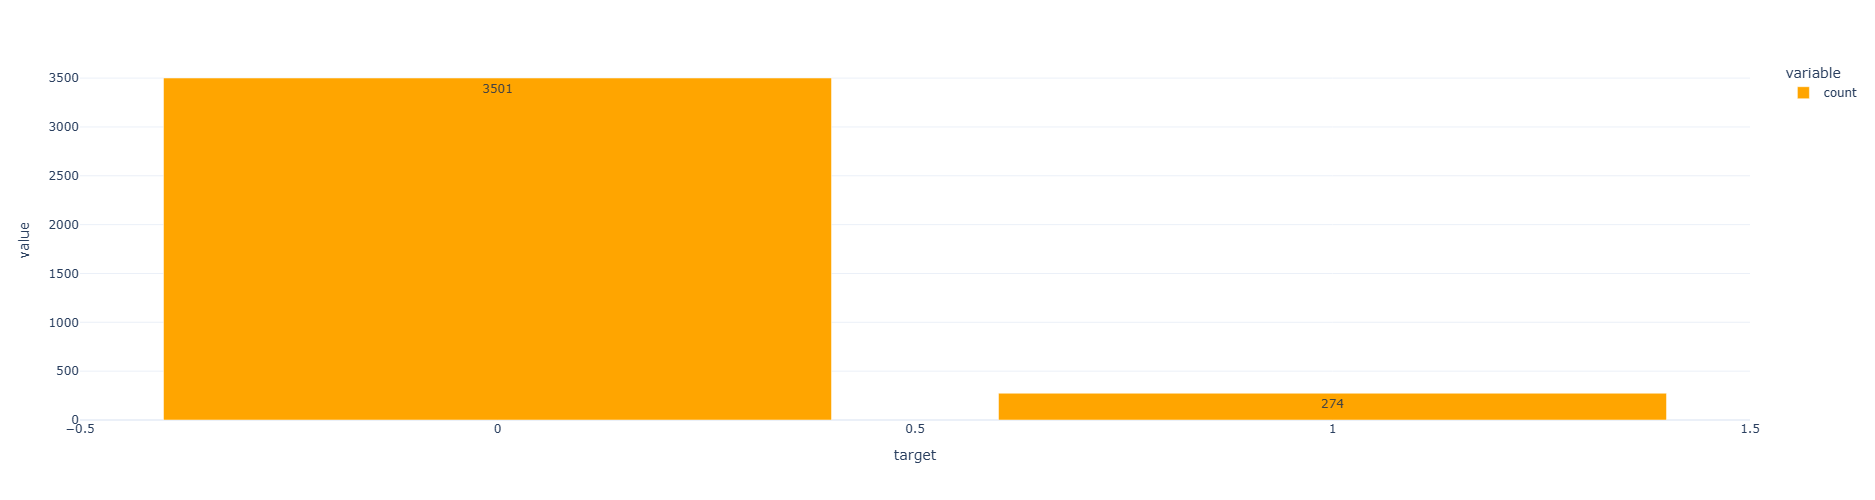

In [35]:
px.bar(data["target"].value_counts(), text_auto=True, color_discrete_sequence=["orange"], width=600, height=500)

In [36]:
print("Ratio :", data["target"].value_counts().iloc[1] / data["target"].value_counts().iloc[0])

Ratio : 0.07826335332762067


In [37]:
val_data = data.iloc[3000:].copy()
data = data.iloc[:3000].copy()

In [38]:
model = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["target"]), data["target"], random_state=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)
accuracy_score(y_test, predictions)

0.9426666666666667

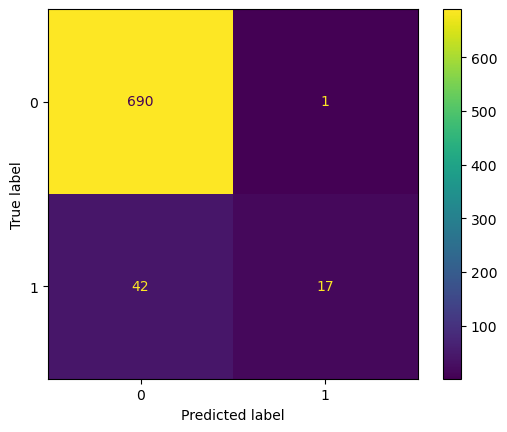

In [39]:
cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()

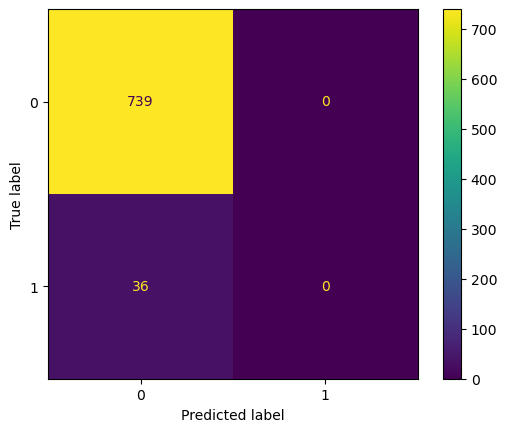

In [40]:
X_val = val_data.drop(columns="target")
y_val = val_data[["target"]]
predictions = model.predict(X_val)
predictions = pd.DataFrame(predictions, index=X_val.index)
cm = confusion_matrix(y_val, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [41]:
accuracy_score(y_val, predictions)

0.9535483870967741

In [42]:
X = data.drop(columns=["target"])
y = data[["target"]]
# define data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# train model
model.fit(X_train, y_train)
# predict test with PROBA ###
predictions = model.predict_proba(X_test)
############################
predictions = pd.DataFrame(predictions, index=X_test.index)
# retrieve just the probabilities for the positive class
predictions = predictions.iloc[:, 1]

from sklearn.metrics import precision_score, recall_score

precision = []
recall = []

for threshold in np.arange(0, 1.1, 0.1):
    preds = np.where(predictions >= threshold, 1, 0)
    precision.append(precision_score(y_test, preds))
    recall.append(recall_score(y_test, preds))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [43]:
auc_pr = pd.DataFrame([np.arange(0, 1.1, 0.1), precision, recall]).T
auc_pr.columns = ["threshold", "precision", "recall"]

In [44]:
auc_pr.iloc[:-1]

,threshold,precision,recall
0,0.0,0.066667,1.00
1,0.1,0.237838,0.88
2,0.2,0.368421,0.70
3,0.3,0.459016,0.56
4,0.4,0.555556,0.40
5,0.5,0.538462,0.28
6,0.6,0.687500,0.22
7,0.7,1.000000,0.14
8,0.8,1.000000,0.10
9,0.9,1.000000,0.02


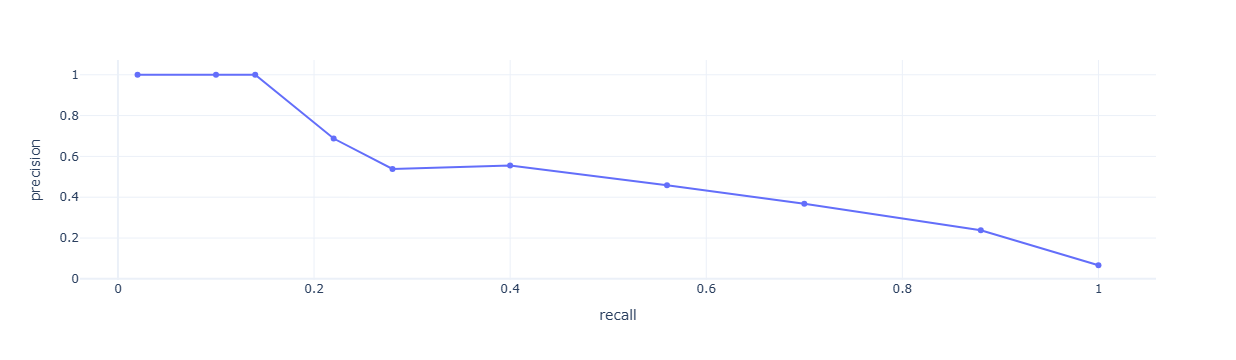

In [45]:
px.line(auc_pr.iloc[:-1], x="recall", y="precision", markers=True)

In [46]:
auc(auc_pr["recall"], auc_pr["precision"])

0.511839819352438

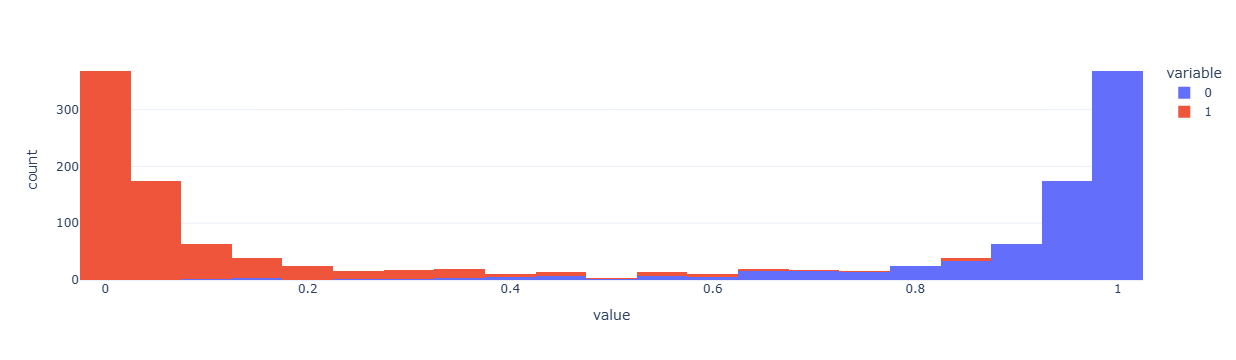

In [47]:
px.histogram(model.predict_proba(X_test))

# Next

ratio fold 0 for train: 0.08 and for test: 0.08
ratio fold 1 for train: 0.08 and for test: 0.08
ratio fold 2 for train: 0.08 and for test: 0.08
ratio fold 3 for train: 0.08 and for test: 0.08
ratio fold 4 for train: 0.08 and for test: 0.08


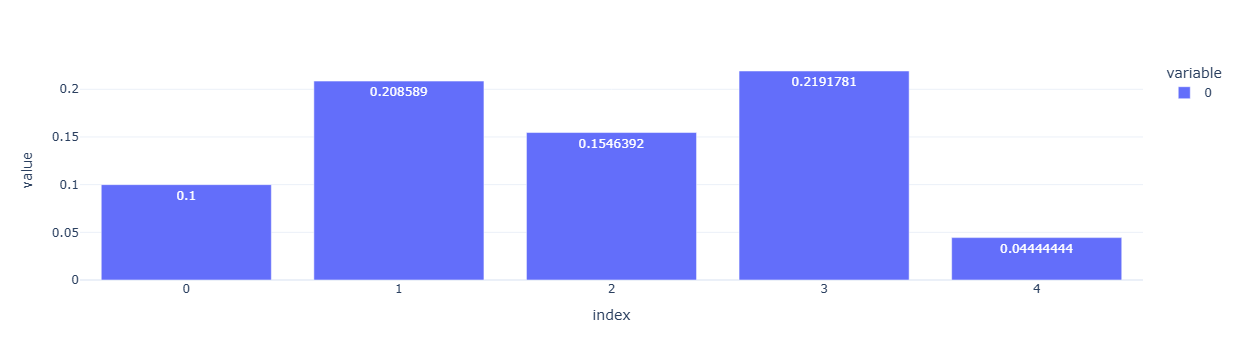

f1_score : 0.14537013178983438


In [52]:
save_models = []

# sm = SMOTE(random_state=42, sampling_strategy=0.5)


def xval_function(X, xval, metric, with_class_weights=False):

    xval_object = xval(n_splits=5)
    result = []
    for i, (train_index, test_index) in enumerate(xval_object.split(X.drop(columns="target"), X["target"])):
        # Purge
        # max_index = test_index.max() + 1
        # min_index = test_index.min() - 1
        # train_index = train_index[(train_index > max_index) | (train_index < min_index)]

        X_train = X.drop(columns="target").iloc[train_index]
        X_test = X.drop(columns="target").iloc[test_index]
        y_train = X[["target"]].iloc[train_index]
        y_test = X[["target"]].iloc[test_index]

        print(
            f"ratio fold {i} for train: {round(y_train.sum() / y_train.shape[0], 2).iloc[0]} and for test: {round(y_test.sum() / y_test.shape[0], 2).iloc[0]}"
        )

        if with_class_weights:
            model = DecisionTreeClassifier(class_weight={0: 1, 1: 10})
        else:
            model = DecisionTreeClassifier()
        model.fit(X_train, y_train)
        save_models.append(model)
        preds = model.predict(X_test)
        result.append(metric(y_test, preds))
    return result


data = 

distribution_xval = xval_function(data, StratifiedKFold, f1_score, with_class_weights=False)
display(px.bar(distribution_xval, text_auto=True))
print(f"f1_score : {np.mean(distribution_xval)}")